# Homework #7 (Due 10/30/2019, 11:59pm)
## Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators: Tanveer Karim**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
%matplotlib inline

In [2]:
# Plot configs
fig_wide = (11, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

## Problem Description: Bayesian Neural Network Regression
In Lab #7, you will explore MLE models for regression with neural networks. For contrast, in this homework you will explore Bayeisan models for regression with neural networks -- essentially, you will place priors on the network parameters $\mathbf{W}$ and infer the posterior $p(\mathbf{W}|\text{Data})$. These Bayesian models are called ***Bayesian neural networks***. The data for this regression problem is in `HW7_data.csv`. You are provided an implementation of a neural network as well as an example of how to use it -- but feel free to implement your own version!

### Part I: Implement Hamiltonian Monte Carlo

1. (**The Sampler**) Implement Hamiltonian Monte Carlo with:
  - Euclidean-Gaussian Kinetic Energy, with mass $m=1$ (see Lecture #12 Notes)
  - Leap-frog integrator<br><br>

2. (**Unit Test**) Check that your implementation is correct by running it on a standard normal distribution $\mathcal{N}(0, 1)$ as your target distribution and initializing at $q = -10$. Check that the histogram of HMC samples (after appropriate burn-in and thinning) look like a standard normal and that the traceplot of $q$ indicates convergence.<br><br>

#### 1.1 HMC Sampler

The general outline for our HMC sampler is the following for approximating a target distribution $\pi(q)$, where $p$ and $q$ are the position and momentum of a walker in our parameters space with dimensionality $\mathbb R^D$:

- Re-rewrite $\pi$ as a potential energy function $U(q) = -\log\pi(q)$
- Pick a kinetic energy function $K$ that can be easily sampled from its Gibbs distribution
- Pick a random $q_0 \in \mathbb R^D$ for a walker
- Repeat N times:
    - Start the walker with a random momentum vector $p$ sampled from $K$
    - Let the walker travel around the parameter space following the Hamiltonian, 
      H = U(q) + K(p)
        - Use your favorite volume-preserving and reversible numerical integration scheme
          here to accomplish this
    - After a set amount of time (T), stop the walker and decided whether to accept 
      its final location or not via a Metropolis-Hastings mechanism 
        - e.g. $\alpha = \text{min}\left[1, 
        \text{exp}\left(\left|H_f - H_0\right|\right)\right]$, 
        accept if $U(0, 1) \le \alpha$
    
This can be done with many walkers to help check for convergence. A synchronized leap-frog algorithm to perform the Hamiltonian integration would look like the following:

\begin{align}
p_{t+1/2} &= p_t - \frac{\epsilon}{2}\frac{\partial U}{\partial q}(q_t) \\
q_{t+1} &= q_t + \epsilon\frac{\partial K}{\partial p}(p_{t + 1/2}) \\
p_{t+1} &= p_{t + 1/2} - \frac{\epsilon}{2}\frac{\partial U}{\partial q}(q_{t+1}) \quad,
\end{align}

where $t$ is the current step and $\epsilon$ is its duration. All we need now is a kinetic energy distribution that we can sample from. Using a Euclidean-Gaussian kinetic energy, we have the following:

\begin{align}
K(p) = \frac{1}{2} p^\top M^{-1} p + \frac{1}{2}\log|M| + \frac{D}{2} \log(2\pi) \quad,
\end{align}

where $M = m \mathbf{I}_{D\times D}$. This is awesome because if we write it's corresponding Gibbs distribution, we have:

\begin{align}
\pi_K(p) = \frac{1}{Z}\exp\left[-K(p)\right] 
= \frac{1}{Z} \frac{1}{(2\pi)^{D/2}|M|^{1/2}} 
\exp\left(-\frac{1}{2}p^\top M^{-1} p\right) \quad,
\end{align}

which is the pdf for the multivariate normal $\mathcal N(0, M)$! Assuming $M$ is positive definite, we know this kind of pdf already integrates to one, so $Z = 1$. The implementation for this HMC scheme is shown below.

In [3]:
# HMC implementation
def HMC(*, q0, U, K, p_samp, N, integrator, L, eps):
    q_current = q0 # place walker
    # calculates gradients needed for integrator
    dUdq = grad(U)
    dKdp = grad(K)
    samples = [q_current]
    accept = 0 # acceptance rate
    print("Progress")
    print("--------")
    for n in range(N):
        p_current = p_samp() # kick-off momentum of walker
        # travel according to Hamiltonian
        q_prop, p_prop = integrator(
            q0=q_current,
            p0=p_current,
            dqdt=dKdp,
            dpdt=dUdq,
            L=L,
            eps=eps,
        )
        
        # M-H accept/reject step
        H_prop = U(q_prop) + K(p_prop)
        H_current = U(q_current) + K(p_current)
        #print(q_current)
        #print(U(q_current), K(p_current))
        log_alpha = np.min([0, H_current - H_prop])
        log_U = np.log(np.random.uniform())
        if log_U <= log_alpha:
            accept += 1
            q_current = q_prop
            
        # progress report
        if (n % int(0.1*N) == 0) and (n > 0): 
            print(f"{n}/{N}")
        samples.append(q_current)
        
    samples = np.array(samples).reshape(len(samples), len(q_current))
    return(samples), accept / N
    
def leap_frog(*, q0, p0, dqdt, dpdt, L, eps):
    # integrates q and p given dq/dt, dp/dt
    q_t, p_t = q0, p0
    for l in range(L):
        p_t_half = p_t - 0.5*eps*dpdt(q_t) # half step
        q_t_full = q_t + eps*dqdt(p_t_half) # full step
        p_t_full = p_t_half - 0.5*eps*dpdt(q_t_full) # half step
        
        # update
        p_t = p_t_full
        q_t = q_t_full
    
    return np.array([q_t, -p_t]) # momentum flip

#### 1.2 Unit test

Applying our HMC sampler to the toy model of the normal distribution produces the following results:

Running sampler...

Sampler params: 
U: <function <lambda> at 0x1a20d5add0>
p_samp: <function <lambda> at 0x1a20d5aef0>
K: <function <lambda> at 0x1a20d88050>
N: 500
integrator: <function leap_frog at 0x1a20d5ad40>
q0: [[-10.]]
L: 5
eps: 1.5
Progress
--------
50/500
100/500
150/500
200/500
250/500
300/500
350/500
400/500
450/500

Sampling finished in 2.712 s
accept rate: 0.808
burned first 50 samples and thinned every 2
initial sample size: 500
final sample size: 226


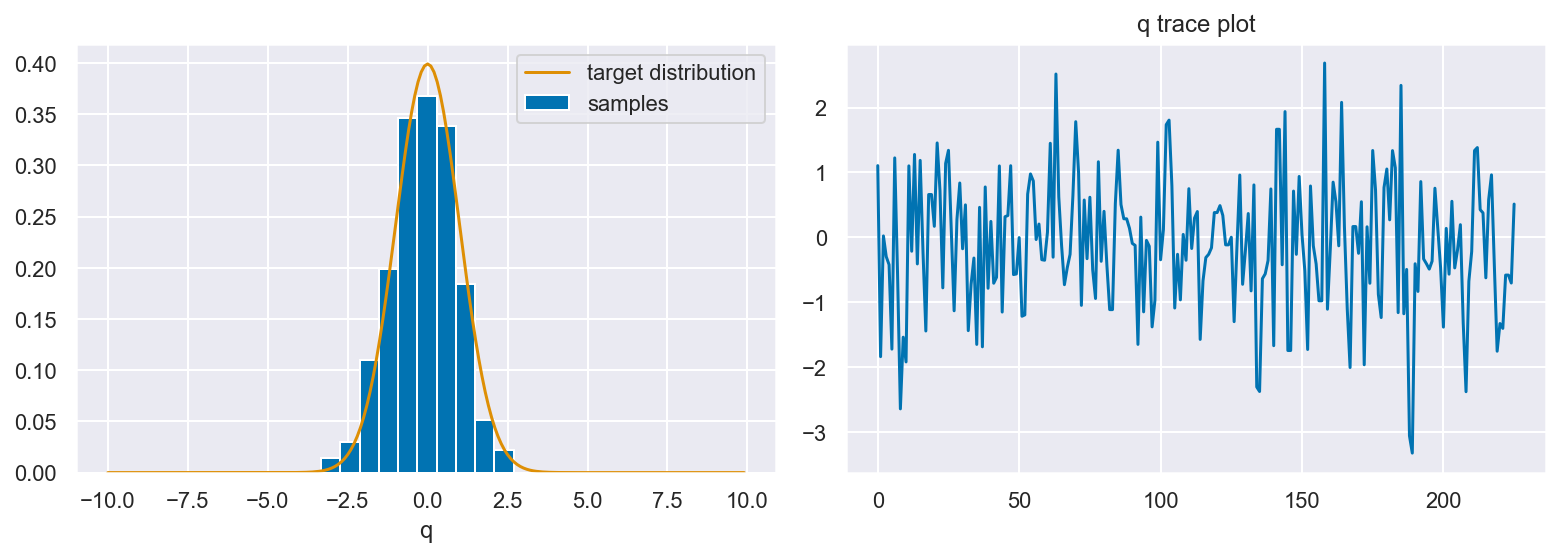

In [4]:
# set inputs
HMC_unittest_params = {}
###############################
# potential energy distribution
###############################
target = sp.stats.norm.pdf # target distribution
HMC_unittest_params["U"] = lambda q: -np.log(target(q)) # computes potential energy
################################
# kinetic energy distribution
################################
mean = np.array([0]) 
D = len(mean) # dimensionality
m = 1. # mass
M = m*np.eye(D) # mass matrix
p_samp = lambda: np.random.multivariate_normal(mean=mean, cov=M).reshape(D, 1)
M_inv = np.linalg.inv(M)
c1 = 0.5*np.log(np.linalg.det(M))
c2 = 0.5*D*np.log(2*np.pi)
K = lambda p: 0.5*np.transpose(p)@M_inv@p + c1 + c2 # calculates kinetic energy
HMC_unittest_params.update({
    "p_samp":p_samp,
    'K': K
})
##########################
# simulation parameters
##########################
HMC_unittest_params.update({
'N': 500, # number of steps
"integrator": leap_frog, # numerical integrator
"q0":  np.array([-10.]).reshape(D, 1), # starting point
'L': 5, # number of integration steps
"eps": 1.5, # integration step interval
})

# run HMC
print("Running sampler...")
print("\nSampler params: ")
for k, v in HMC_unittest_params.items():
    print(f"{k}: {v}")
start = time.perf_counter()
samples, accept_rate = HMC(**HMC_unittest_params)
print(f"\nSampling finished in {(time.perf_counter() - start):.3f} s")

# display results
fig, axes = plt.subplots(1, 2, figsize=fig_wide)
print(f"accept rate: {accept_rate}")
N = len(samples)
burn = int(0.1*N)
thin = 2
print(f"burned first {burn} samples and thinned every {thin}")
samples_reduced = samples[burn::thin]
N = HMC_unittest_params['N']
print(f"initial sample size: {N}")
print(f"final sample size: {len(samples_reduced)}")

axes[0].hist(samples_reduced, density=True, label="samples")
x = np.arange(-10, 10, 0.1)
axes[0].plot(x, target(x), label="target distribution")
axes[0].set_xlabel('q')
axes[0].legend()

axes[1].plot(samples_reduced)
axes[1].set_title("q trace plot")
      
fig.tight_layout()

Not bad! Visually, the samples mirror the target distribution and the trace plot appears to converge.

### Part II: Sample from the Posterior of a Bayesian Neural Network

1. (**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}

$\quad\quad$where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).

$\quad\quad$Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
  
$\quad\quad$***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.<br><br>
  
2. (**The Unnormalized Posterior is Enough**) By Bayes rule, the posterior $p(\mathbf{W}|\text{Data})= \frac{p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W})}{\mathcal{Z}}$, where $\mathcal{Z}$ is a normalizing constant defined by a complicated integral. Argue that we do not need to evaluate $\mathcal{Z}$ for HMC sampling from the posterior. In particular, examine the Metropolis-Hasting acceptance mechanism in HMC and argue that the normalizing constant is not needed; furthermore, examine the gradient update steps in the leap-frog integrator and argue that we do not need the normalizing constant in the gradient update.<br><br>

3. (**Sample from the Posterior**) Use HMC to sample from the posterior of the Bayesian neural network. Start with the following settings for your sampler:
``` python
params = {'step_size':1e-3, 
          'leapfrog_steps':50, 
          'total_samples':10000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights}
```
  Note that you should initialize with the MLE model, otherwise convergence may be slow. Please feel free to tweak these design choices as you see fit!<br><br>
  
4. (**Visualize the Posterior Predictive**) Visualize 100 samples, randomly selected, from your posterior samples of $\mathbf{W}$, by ploting their predicted values plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1)))
```
  where `sample` is a posterior sample of $\mathbf{W}$.<br><br>

5. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 

  Not required for you to worry about for this problem, but note that this is a Monte Carlo estimation of an integral, so you'll need to worry about variance and all that.<br><br>
  
6. (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

In [5]:
data = pd.read_csv('HW7_data.csv')
x = data['x'].values
y = data['y'].values
data

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942
5,-4.0,-0.444701
6,4.0,0.015153
7,4.4,1.820702
8,4.8,1.824240
9,5.2,1.476832


In [6]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [7]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [8]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':6000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

Iteration 0 lower bound 65.11668053773148; gradient mag: 164.73210946091572
Iteration 100 lower bound 52.864360467566954; gradient mag: 56.95458639088454
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.311751879565843
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.779125916898227
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.210455188665925
Iteration 1200 lower bound 18.43436747168103; gradient mag: 15.09

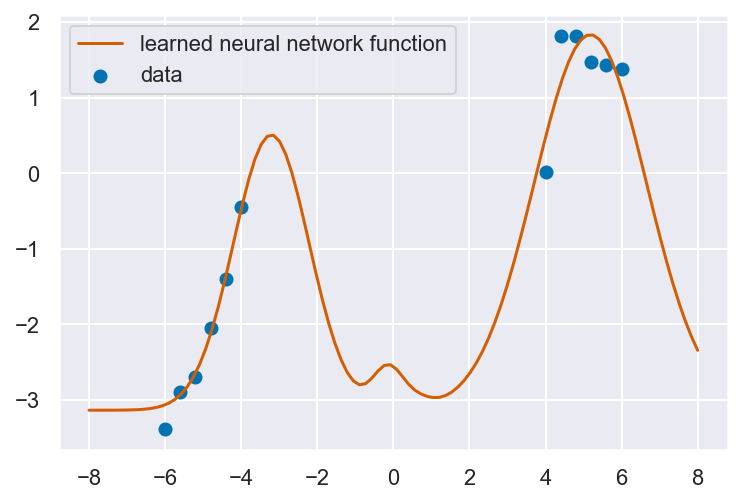

In [9]:
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(nn.weights, x_test.reshape((1, -1)))
plt.scatter(x, y, label='data')
plt.plot(x_test, y_test.flatten(), color='r', label='learned neural network function')
plt.legend(loc='best')
plt.show()

#### 2.1 BNN Model

Writing out each distribution, we have

\begin{align}
\ln\left[p(W)\prod_{n=1}^N Y_n\right] 
&= \ln p(W) + \sum_{n=1}^N \ln Y_n \\
&= -\frac{1}{2}\ln\left[(2\pi)^D\left|\Sigma\right|\right]
- \frac{1}{2}W^\top\Sigma^{-1}W 
+ \sum_{n=1}^N\left[
-\frac{1}{2}\ln(2\pi\sigma^2) - \frac{\left(y_n - y_n^\text{pred}\right)^2}{2\sigma^2}
\right] \\
&= -\frac{1}{2}\ln\left[(2\pi)^D\left|\Sigma\right|\right]
- \frac{1}{2}W^\top\Sigma^{-1}W 
-\frac{N\ln(2\pi\sigma^2)}{2}
-\frac{1}{2\sigma^2}\sum_{n=1}^N\left(y_n - y_n^\text{pred}\right)^2 \\
&= - \frac{1}{2}W^\top\Sigma^{-1}W
- \frac{1}{2\sigma^2}\sum_{n=1}^N\left(y_n - y_n^\text{pred}\right)^2
+ \text{const} \quad,
\end{align}

where $y_\text{pred}$ is determined from the forward pass in our BNN with `nn.forward(W, x)`. The constant term does not affect the optimal weight values so we can drop it. This is already in log-space, so the potential energy is just the negative of this. In `autograd` this looks like

``` python
def neg_ln_target(W):
    y_pred = nn.forward(np.transpose(W), np.transpose(x))[0, 0].reshape(-1, 1)
    ln_prior = -0.5*np.transpose(W)@Sigma_inv@W
    ln_likelihood = - 1./(2*sigma_sq) * np.sum((y - y_pred)**2)
    return -1.*(ln_prior + ln_likelihood)
HMC_BNN_params["U"] = neg_ln_target # computes potential energy
```

#### 2.2 The Unnormalized Posterior is Enough 

From [Betancourt](https://arxiv.org/pdf/1701.02434.pdf) pg. 39, we see that for symplectic integration schemes (like leap frog) and reversible transitions (momentum flip), the Metropolis Hastings acceptance criteria reduces down to just the difference in the Hamiltonian between each step. Since the potential energy within the Hamiltonian goes like the log of the target distribution, the $\mathcal Z$ in the denominator cancels out and the kinetic energy just comes along for the ride.

#### 2.3 Sample from the Posterior

Using the MLE initialized weights from `nn.weights`, we get the following results:

In [10]:
# set inputs
HMC_BNN_params = {}
###############################
# potential energy distribution
###############################
N = len(x) if len(x) == len(y) else print("data length mismatch")
W = nn.weights.T
D = len(W)
Sigma = 5**2.*np.eye(D)
Sigma_inv = np.linalg.inv(Sigma)
sigma_sq = 0.5**2
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
def neg_ln_target(W):
    y_pred = nn.forward(np.transpose(W), np.transpose(x))[0, 0].reshape(-1, 1)
    ln_prior = -0.5*np.transpose(W)@Sigma_inv@W
    ln_likelihood = - 1./(2*sigma_sq) * np.sum((y - y_pred)**2)
    return -1.*(ln_prior + ln_likelihood)
HMC_BNN_params["U"] = neg_ln_target # computes potential energy
################################
# kinetic energy distribution
################################
mean = np.zeros(D) 
m = 1. # mass
M = m*np.eye(D) # mass matrix
p_samp = lambda: np.random.multivariate_normal(mean=mean, cov=M).reshape(D, 1)
M_inv = np.linalg.inv(M)
c1 = 0.5*np.log(np.linalg.det(M))
c2 = 0.5*D*np.log(2*np.pi)
HMC_BNN_params.update({
    "p_samp":p_samp,
    'K': lambda p: 0.5*np.transpose(p)@M_inv@p + c1 + c2 # calculates kinetic energy
})
##########################
# simulation parameters
##########################
HMC_BNN_params.update({
'N': 300, # number of steps
"integrator": leap_frog, # numerical integrator
"q0": W, # starting point
'L': 50, # number of integration steps
"eps": 1e-3, # integration step interval
})

# run HMC
print("Sampler params")
print("----------------")
for k, v in HMC_BNN_params.items():
    print(f"{k}: {v}")
print("\nRunning sampler...\n")
start = time.perf_counter()
samples, accept_rate = HMC(**HMC_BNN_params)
print(f"\nSampling finished in {(time.perf_counter() - start):.3f} s")
print(f"final accept rate: {accept_rate}")

Sampler params
----------------
U: <function neg_ln_target at 0x10d577ef0>
p_samp: <function <lambda> at 0x10c798050>
K: <function <lambda> at 0x10c798170>
N: 300
integrator: <function leap_frog at 0x1a20d5ad40>
q0: [[ 1.76405283]
 [ 0.71098779]
 [ 0.48033609]
 [ 2.2408932 ]
 [ 1.86755799]
 [-0.97727776]
 [ 2.28122995]
 [-2.4874205 ]
 [-0.10321885]
 [ 0.4105985 ]
 [ 0.1440435 ]
 [ 3.64522151]
 [ 4.9710269 ]
 [ 0.12167502]
 [ 0.44386323]
 [-3.13432354]]
L: 50
eps: 0.001

Running sampler...

Progress
--------
30/300
60/300
90/300
120/300
150/300
180/300
210/300
240/300
270/300

Sampling finished in 45.737 s
final accept rate: 1.0


This was done for only 300 steps for the sake of time.

#### 2.4 Visualize the Posterior Predictive

We can take a look at how our sampler did by viewing some predicted values on synthetic data. Doing this for 100 randomly selected samples produces the following plot:

In [11]:
np.random.normal()

0.29708582112762827

burned first 30 samples and thinned every 2
initial sample size: 300
final sample size: 136


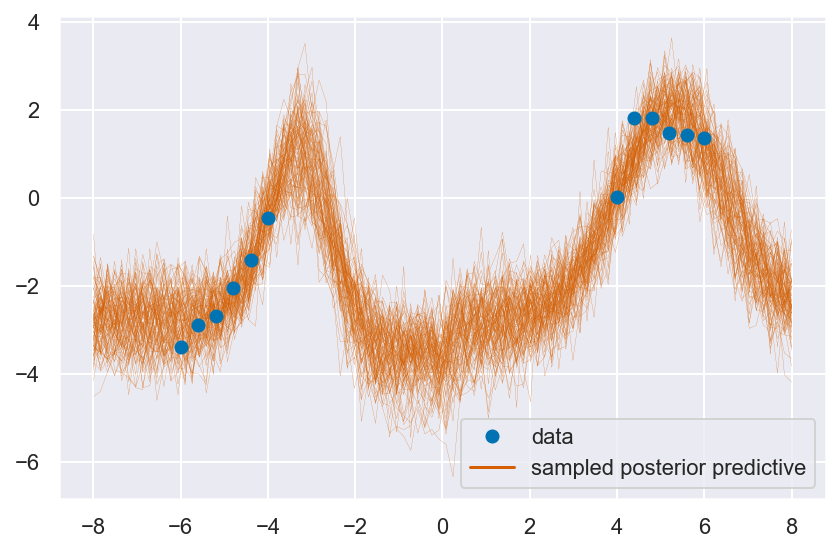

In [12]:
# burn and thin
N = len(samples)
burn = int(0.1*N)
thin = 2
print(f"burned first {burn} samples and thinned every {thin}")
d = 0
samples_reduced = samples[burn::thin, :]
N = HMC_BNN_params['N']
print(f"initial sample size: {N}")
print(f"final sample size: {len(samples_reduced)}")

# display results
fig, ax = plt.subplots()
N_test = 100
x_test = np.linspace(-8, 8, N_test).reshape(-1, 1)
np.random.shuffle(samples_reduced)
W_sampled = samples_reduced[:N_test, :]
noise = np.random.normal(loc=0, scale=0.5, size=(len(x_test), len(x_test)))
for W_samp, n in zip(W_sampled, noise):
    n = n.reshape(-1, 1)
    W_samp = W_samp.reshape(-1, 1)
    y_test = nn.forward(W_samp.T, x_test.T).reshape(-1, 1) + n # add some noise
    ax.plot(x_test[:, 0], y_test[:, 0], c='r', lw=0.1)

ax.plot(x, y, 'o', label="data")
ax.plot([], 'r', label="sampled posterior predictive")
ax.legend()      
fig.tight_layout()

This visualization shows sampled models, but it does not give us a sense of the uncertainty. Let's do that next.

#### 2.5 Computing the Fit

We can compute the posterior predictive and confidence region by bootstrapping samples as shown below:

In [13]:
def log_like(y_actual, y_pred):
    ln_likelihood = 1./(2*sigma_sq) * np.sum((y_actual - y_pred)**2)
    return ln_likelihood

trials = 2
y_test_nn = []
log_lkhd_nn = []
for i in range(trials):
    if i % 10 == 0:
        print('trial:', i)
        
    #generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x)), size=len(x))
    bootstrap_x = x[indices]
    bootstrap_y = y[indices]
    
    #fit neural network
    ###define design choices in gradient descent
    random = np.random.RandomState(i)
    params = {'step_size':1e-3, 
          'max_iteration':6000, 
          'random_restarts':1}

    #fit my neural network to minimize MSE on the given data

    #instantiate a Feedforward neural network object
    nn = Feedforward(architecture, random=random)
    nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
    #predict on x_test
    y_test = nn.forward(nn.weights, x_test.reshape((1, -1))).flatten()
    y_test_nn.append(y_test)
    
    #compute log likelihood on observed data
    y_train = nn.forward(nn.weights, x.reshape((1, -1))).flatten()
    log_lkhd_nn.append(log_like(bootstrap_y, y_train))

trial: 0
Iteration 0 lower bound 65.11668053773148; gradient mag: 164.73210946091572
Iteration 100 lower bound 52.864360467566954; gradient mag: 56.95458639088454
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.311751879565843
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.779125916898227
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.210455188665925
Iteration 1200 lower bound 18.43436747168103; gradient m

Iteration 4400 lower bound 0.23192719383742466; gradient mag: 0.19592146798026802
Iteration 4500 lower bound 0.22299252152345464; gradient mag: 0.17493037718278967
Iteration 4600 lower bound 0.21515820464471672; gradient mag: 0.15691061248452406
Iteration 4700 lower bound 0.2082375610751878; gradient mag: 0.14150908100238516
Iteration 4800 lower bound 0.20208557539981686; gradient mag: 0.1284247099072825
Iteration 4900 lower bound 0.1965693098907449; gradient mag: 0.11723180689223503
Iteration 5000 lower bound 0.19158397839866537; gradient mag: 0.10780260305346476
Iteration 5100 lower bound 0.1870458894937593; gradient mag: 0.09984878131128337
Iteration 5200 lower bound 0.18288873956562388; gradient mag: 0.09631771990071036
Iteration 5300 lower bound 0.17905873185909568; gradient mag: 0.0875237393714364
Iteration 5400 lower bound 0.17550217349213643; gradient mag: 0.08280285436547803
Iteration 5500 lower bound 0.17217986800200274; gradient mag: 0.07883798562190353
Iteration 5600 lower 

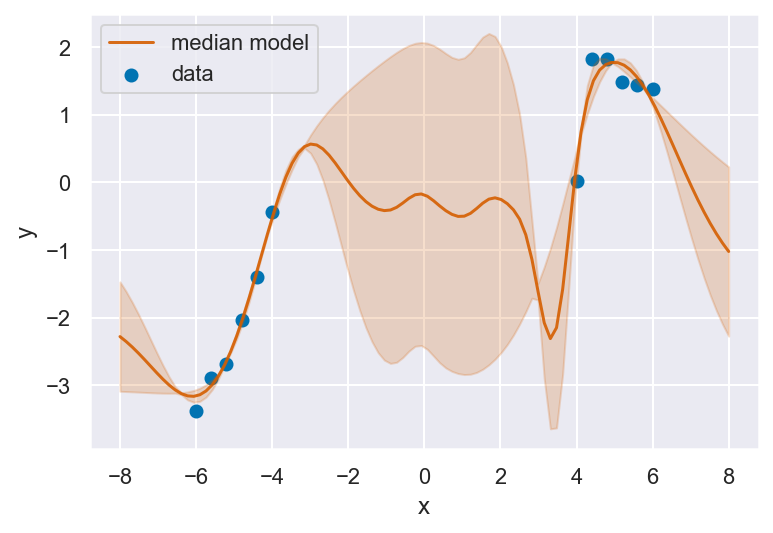

In [14]:
# display results
fig, ax = plt.subplots()
ax.scatter(x, y, color='b', label='data')

#compute 95% predictive interval
y_test_nn = np.array(y_test_nn)

y_test_nn_ub = np.percentile(y_test_nn, 97.5, axis=0)
y_test_nn_mean = y_test_nn.mean(axis=0)
y_test_nn_lb = np.percentile(y_test_nn, 2.5, axis=0)

#plot 95% predictive interval
ax.fill_between(x_test[:, 0], y_test_nn_ub, y_test_nn_lb, color='r', alpha=0.2)
ax.plot(x_test[:, 0], y_test_nn_mean, color='r', alpha=0.9, label="median model")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()

This was done for only 2 trials to save time. We can see that the models are much more constrained near the data. 

#### 2.6  Model Evaluation

Aleatoric uncertainty captures noise inherent in the observations while epistemic uncertainty accounts for uncertainty in the model. Bad models would have the same epistemic error everywhere. This would not tell us much, so we would want to avoid/minimize this type of error. By definition, we cannot escape aleatoric uncertainty and it is something that we have to live with no matter the model.